In [1]:
###

# Example notebook testing fast sliced W2 on Gaussian blobs

###

In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

import mra_utils as mra

In [3]:
def gaussian_2d(N, A=1, sig_x=1, sig_y=1):
    """returns simple 2D Gaussian over range -3 to 3 of size NxN"""
    
    # Make this a better function
    
    xs = np.linspace(-3, 3, N)
    ys = np.linspace(-3, 3, N)

    x, y = np.meshgrid(xs, ys)

    g = A*np.exp(-((x**2 / 2*sig_x**2) + (y**2 / 2*sig_y**2)))
    
    return g

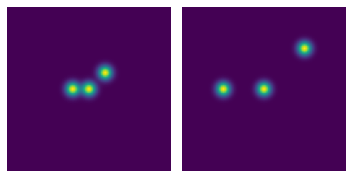

In [4]:
### Generate Gaussian blob image with and without deformation
### - use odd size image for centering

amp = 1000  # a.u.
ny = 101
nx = 101

g = gaussian_2d(ny, A=amp, sig_x=3, sig_y=3)  # using large amplitude because of scaling

x1 = np.zeros((ny, nx))
x2 = np.zeros((ny, nx))

x1[50, 40] = 1
x1[50, 50] = 1
x1[40, 60] = 1

x2[50, 25] = 1
x2[50, 50] = 1
x2[25, 75] = 1

x1 = mra.ift2(mra.ft2(x1) * g)
x2 = mra.ift2(mra.ft2(x2) * g)

mra.two_plot(x1, x2)

In [5]:
### Inputs ###

use_deformed_blobs = False
upsample = True
add_noise = False
apply_mask = True

angular_sampling = np.arange(0, 360, 1)

upsample_scale = 3

sigma = mra.get_sigma_for_snr(x1, 1)

translation = [0, 0]  # pixel translation for y2

angle = 200  # angle to rotate y2

In [6]:
### generate images
### - order is: upsample -> add noise -> rotate/translate -> mask

np.random.seed(0)

if use_deformed_blobs:
    y1 = x1.copy()
    y2 = x2.copy()
else:
    y1 = x1.copy()
    y2 = x1.copy()

if upsample:
    y1 = mra.fourier_upsample(y1, upsample_scale)
    y2 = mra.fourier_upsample(y2, upsample_scale)
    ny, nx = y1.shape
    
if add_noise:
    y1 = y1 + np.random.poisson(sigma, y1.shape)
    y2 = y2 + np.random.poisson(sigma, y2.shape)
    
y2 = mra.translate(mra.rotate(y2, angle), translation)

if apply_mask:
    rdists = mra.radial_distance_grid([ny, nx])
    mask = mra.sphere_mask(rdists)  
    y1 = y1 * mask
    y2 = y2 * mask 

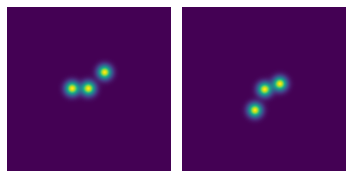

In [7]:
### preprocess images

y1 = mra.normalize_image_to_unit_mass(y1)
y2 = mra.normalize_image_to_unit_mass(y2)

mra.two_plot(y1, y2)

In [8]:
### compute fast sliced W2
# I think this runs much slower when Aspire functions are from module?

start_time = time.time()

y1_rt = mra.fast_radon_transform(y1, angular_sampling)
y2_rt = mra.fast_radon_transform(y2, angular_sampling)

grid = np.linspace(0, 1, nx) # uniform grid with n_points equal to signal length
values = np.arange(nx)

y1_icdf = mra.convert_radon_transform_to_inverse_cdf(y1_rt, grid, values)
y2_icdf = mra.convert_radon_transform_to_inverse_cdf(y2_rt, grid, values)

dist_matrix = np.array([mra.fast_shift_computation(y1_icdf[j, :], y2_icdf[j, :]) for j in range(nx)])  
dists = np.sum(dist_matrix, axis=0)
angle_est = angular_sampling[np.argmin(dists)]

t2 = (time.time() - start_time)
print(t2)

2023-06-27 12:58:41,260 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2023-06-27 12:58:41,263 INFO Trying NFFT backend finufft
2023-06-27 12:58:41,332 INFO NFFT backend finufft usable.
2023-06-27 12:58:41,333 INFO Trying NFFT backend cufinufft
2023-06-27 12:58:41,335 INFO NFFT backend cufinufft not usable:
	No module named 'pycuda'
2023-06-27 12:58:41,336 INFO Trying NFFT backend pynfft
2023-06-27 12:58:41,338 INFO NFFT backend pynfft not usable:
	No module named 'pynfft'
2023-06-27 12:58:41,350 INFO Selected NFFT backend = finufft.
2023-06-27 12:58:41,731 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
0.5399250984191895


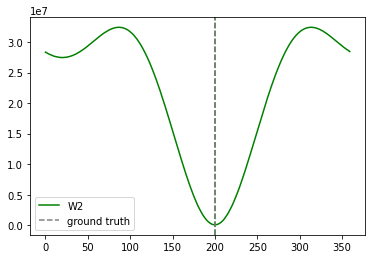

GT angle:  200
W2 angle:  200


In [9]:
plt.figure(figsize=(6,4))
plt.plot(angular_sampling, dists, color='green', label='W2')
plt.axvline(angle_est, color='green', linestyle='--')
plt.axvline(angle, color='gray', linestyle='--', label='ground truth')
plt.legend()
plt.show()

print('GT angle: ', angle)
print('W2 angle: ', angle_est)

74630.00000045821
72137


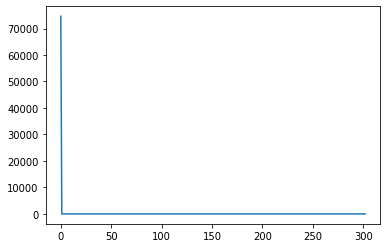

In [10]:
### why is dists min not zero?
### actually seems like it is except first point, maybe a NUFFT thing ?

plt.plot(dist_matrix[:, np.argmin(dists)])

print(np.amin(dists))
print(y1.size - np.sum(~mask))  # i.e. maybe the 0th freq or number of pixels?

2023-06-27 12:58:42,117 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.


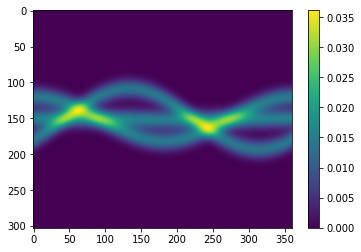

-5.390076928978279e-10


In [11]:
### also there are 'negative' values in RT that can affect results
### either need to assertions or extra filtering step
### currently just replacing the negatives with zero in the get_cdf_from_pdf function

z = mra.fast_radon_transform(y1, angular_sampling)

plt.imshow(z)
plt.colorbar()
plt.show()
print(np.amin(z))